### 1.Data Preprocessing & Exploration

#### Import Libraries

In [1]:
import re
import nltk
import torch
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import tensorflow as tf
from sklearn.svm import SVC
import torch.optim as optim
from datasets import Dataset
import gensim.downloader as api
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from concurrent.futures import ThreadPoolExecutor
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from torch.utils.data import DataLoader, TensorDataset
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report
from transformers import BertTokenizer, TFBertForSequenceClassification, Trainer, TrainingArguments,BertModel

In [2]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dssm3\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dssm3\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dssm3\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### Load & Inspect the Dataset

##### Load the dataset

In [3]:
df = pd.read_csv("accident_dataset.csv") # load dataset
data=df.copy()                           # making copy of data set
df.head()                                # printing first 5 entries of data set

,Accident Report,Primary Cause,Secondary Cause,Risk Factor
0,"On 22 Jan 2024, at 06:36 AM, a auto-rickshaw c...",Drunk Driving,NaN,High
1,"On 01 Jan 2024, at 06:23 PM, a two-wheeler col...",Weather Issues,Road Conditions,Moderate
2,"On 08 Jan 2024, at 03:02 AM, a two-wheeler col...",Weather Issues,Seatbelt Violation,Moderate
3,"On 25 Feb 2024, at 12:10 AM, a car collided wi...",Rash Driving,NaN,High
4,"On 23 Jan 2024, at 08:58 AM, a truck collided ...",Seatbelt Violation,Signal Violation,High


##### Inspect the Dataset

In [4]:
# Display basic information about the dataset
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Accident Report  10000 non-null  object
 1   Primary Cause    10000 non-null  object
 2   Secondary Cause  5043 non-null   object
 3   Risk Factor      10000 non-null  object
dtypes: object(4)
memory usage: 312.6+ KB
None


In [5]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
Accident Report       0
Primary Cause         0
Secondary Cause    4957
Risk Factor           0
dtype: int64


In [6]:
# Check for duplicate entries
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")


Number of duplicate rows: 0


In [7]:
# Display basic statistics
print("\nDataset Summary Statistics:")
print(df.describe())


Dataset Summary Statistics:
                                          Accident Report     Primary Cause  \
count                                               10000             10000   
unique                                              10000                 8   
top     On 22 Jan 2024, at 06:36 AM, a auto-rickshaw c...  Signal Violation   
freq                                                    1              1312   

         Secondary Cause Risk Factor  
count               5043       10000  
unique                 8           2  
top     Helmet Violation    Moderate  
freq                 662        6999  


##### Exploratory Data Analysis (EDA)

C:\Users\dssm3\AppData\Local\Temp\ipykernel_2956\3168283102.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df["Primary Cause"], order=df["Primary Cause"].value_counts().index, palette="viridis")


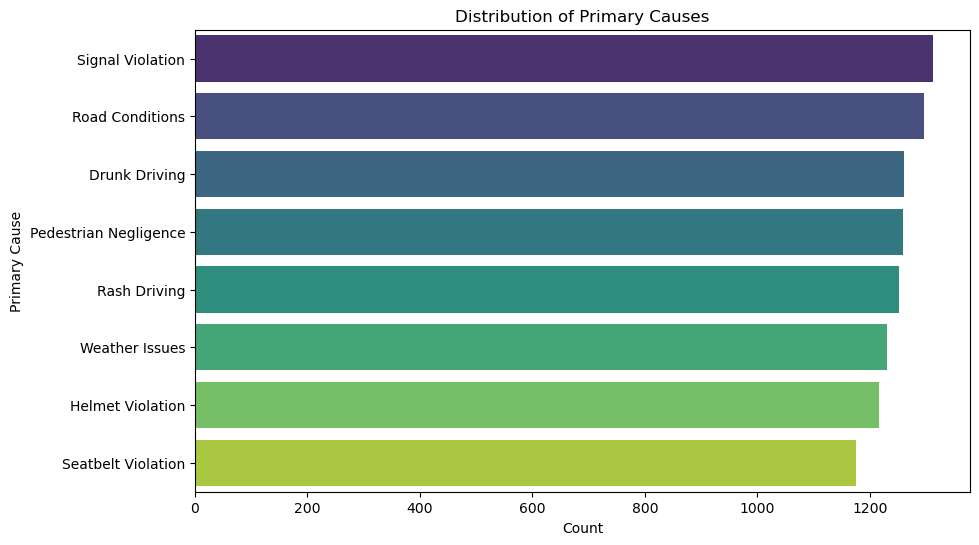

C:\Users\dssm3\AppData\Local\Temp\ipykernel_2956\3168283102.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df["Secondary Cause"], order=df["Secondary Cause"].value_counts().index, palette="viridis")


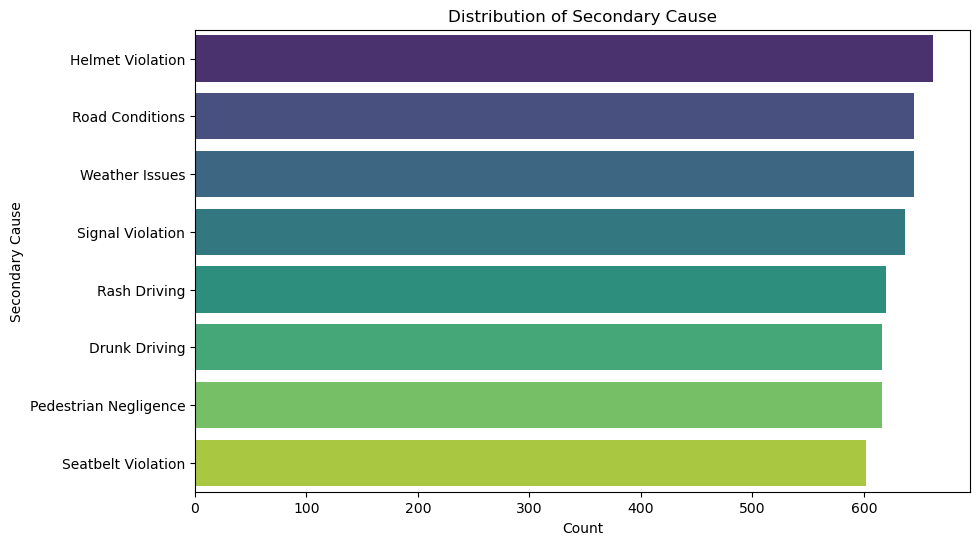

C:\Users\dssm3\AppData\Local\Temp\ipykernel_2956\3168283102.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Risk Factor"], palette="coolwarm")


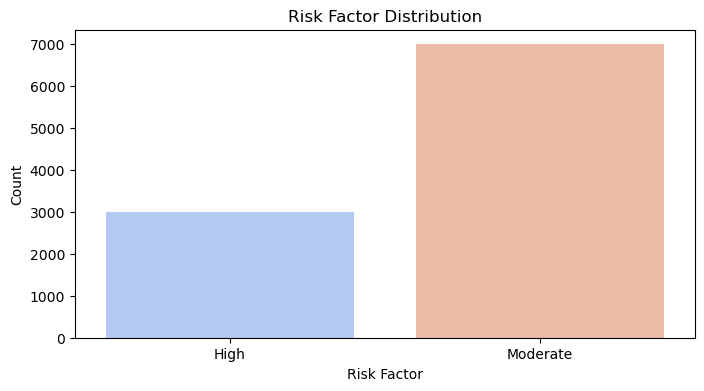

In [8]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10, 6))
sns.countplot(y=df["Primary Cause"], order=df["Primary Cause"].value_counts().index, palette="viridis")
plt.title("Distribution of Primary Causes")
plt.xlabel("Count")
plt.ylabel("Primary Cause")
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(y=df["Secondary Cause"], order=df["Secondary Cause"].value_counts().index, palette="viridis")
plt.title("Distribution of Secondary Cause")
plt.xlabel("Count")
plt.ylabel("Secondary Cause")
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(x=df["Risk Factor"], palette="coolwarm")
plt.title("Risk Factor Distribution")
plt.xlabel("Risk Factor")
plt.ylabel("Count")
plt.show()

### Text cleaning function

In [9]:
def clean_text(text):
    text = text.lower() #Converts the entire text to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Uses regular expressions(re.sub) to remove special characters, punctuation, and symbols
    tokens = word_tokenize(text) #to split the cleaned text into individual words (tokens).
    tokens = [word for word in tokens if word not in stopwords.words('english')] # stop word removal
    return ' '.join(tokens) #Joins the remaining tokens back into a single string with spaces between words.

In [10]:
df['Preprocessed'] = df['Accident Report'].astype(str).apply(clean_text)

In [11]:
df

,Accident Report,Primary Cause,Secondary Cause,Risk Factor,Preprocessed
0,"On 22 Jan 2024, at 06:36 AM, a auto-rickshaw c...",Drunk Driving,NaN,High,22 jan 2024 0636 autorickshaw collided autoric...
1,"On 01 Jan 2024, at 06:23 PM, a two-wheeler col...",Weather Issues,Road Conditions,Moderate,01 jan 2024 0623 pm twowheeler collided truck ...
2,"On 08 Jan 2024, at 03:02 AM, a two-wheeler col...",Weather Issues,Seatbelt Violation,Moderate,08 jan 2024 0302 twowheeler collided car outer...
3,"On 25 Feb 2024, at 12:10 AM, a car collided wi...",Rash Driving,NaN,High,25 feb 2024 1210 car collided bus marine drive...
4,"On 23 Jan 2024, at 08:58 AM, a truck collided ...",Seatbelt Violation,Signal Violation,High,23 jan 2024 0858 truck collided twowheeler out...
...,...,...,...,...,...
9995,"On 22 Feb 2024, at 11:31 PM, a two-wheeler col...",Weather Issues,NaN,Moderate,22 feb 2024 1131 pm twowheeler collided bus ou...
9996,"On 02 Feb 2024, at 02:47 PM, a auto-rickshaw c...",Road Conditions,NaN,Moderate,02 feb 2024 0247 pm autorickshaw collided car ...
9997,"On 02 Feb 2024, at 11:32 AM, a auto-rickshaw c...",Seatbelt Violation,NaN,High,02 feb 2024 1132 autorickshaw collided bus mar...
9998,"On 19 Jan 2024, at 04:03 AM, a auto-rickshaw c...",Drunk Driving,Helmet Violation,High,19 jan 2024 0403 autorickshaw collided truck m...


In [12]:
# Labels to predict  ("multilabel classiication")
labels = ['Primary Cause', 'Secondary Cause', 'Risk Factor']

In [13]:
label_encoders = {}  # Dictionary to store LabelEncoders for each label
for label in labels:  # Iterate through each label ('Primary Cause', 'Secondary Cause', 'Risk Factor')
    le = LabelEncoder()  # Create a new LabelEncoder instance
    df[label] = df[label].astype(str) # Convert label values to strings (ensures no numerical/missing values)
    df[label + '_encoded'] = le.fit_transform(df[label])  # Encode the categorical values into numbers
    label_encoders[label] = le  # Store the LabelEncoder for future use


In [14]:
# Save Label Encoders
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

In [15]:
df

,Accident Report,Primary Cause,Secondary Cause,Risk Factor,Preprocessed,Primary Cause_encoded,Secondary Cause_encoded,Risk Factor_encoded
0,"On 22 Jan 2024, at 06:36 AM, a auto-rickshaw c...",Drunk Driving,nan,High,22 jan 2024 0636 autorickshaw collided autoric...,0,8,0
1,"On 01 Jan 2024, at 06:23 PM, a two-wheeler col...",Weather Issues,Road Conditions,Moderate,01 jan 2024 0623 pm twowheeler collided truck ...,7,4,1
2,"On 08 Jan 2024, at 03:02 AM, a two-wheeler col...",Weather Issues,Seatbelt Violation,Moderate,08 jan 2024 0302 twowheeler collided car outer...,7,5,1
3,"On 25 Feb 2024, at 12:10 AM, a car collided wi...",Rash Driving,nan,High,25 feb 2024 1210 car collided bus marine drive...,3,8,0
4,"On 23 Jan 2024, at 08:58 AM, a truck collided ...",Seatbelt Violation,Signal Violation,High,23 jan 2024 0858 truck collided twowheeler out...,5,6,0
...,...,...,...,...,...,...,...,...
9995,"On 22 Feb 2024, at 11:31 PM, a two-wheeler col...",Weather Issues,nan,Moderate,22 feb 2024 1131 pm twowheeler collided bus ou...,7,8,1
9996,"On 02 Feb 2024, at 02:47 PM, a auto-rickshaw c...",Road Conditions,nan,Moderate,02 feb 2024 0247 pm autorickshaw collided car ...,4,8,1
9997,"On 02 Feb 2024, at 11:32 AM, a auto-rickshaw c...",Seatbelt Violation,nan,High,02 feb 2024 1132 autorickshaw collided bus mar...,5,8,0
9998,"On 19 Jan 2024, at 04:03 AM, a auto-rickshaw c...",Drunk Driving,Helmet Violation,High,19 jan 2024 0403 autorickshaw collided truck m...,0,1,0


### Feature Engineering: TF-IDF Vectorization

In [16]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000) #max_features=5000 ensures that only the top 5000 most important words(based on frequency and relevance) are considered.
X_tfidf = tfidf_vectorizer.fit_transform(df['Preprocessed'])


# Fits the vectorizer to the preprocessed text and transforms it into a sparse matrix representation.
# df['Preprocessed'] contains the cleaned text data.
# The output X_tfidf is a matrix of shape (num_documents, num_features), where:
# Rows represent accident reports.
# Columns represent important words (features).

In [17]:
# Save TF-IDF vectorization
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

### Feature Engineering: Word2Vec

In [18]:
# word2vec_model = api.load("glove-wiki-gigaword-100")
# def get_word2vec_embedding(text):
#     words = text.split()
#     word_vectors = [word2vec_model[word] for word in words if word in word2vec_model]
#     if word_vectors:
#         return np.mean(word_vectors, axis=0)
#     else:
#         return np.zeros(100)
# X_word2vec = np.array([get_word2vec_embedding(text) for text in df['Preprocessed']])

### Feature Engineering: BERT Embeddings

In [19]:
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# bert_model = BertModel.from_pretrained("bert-base-uncased")

# def get_bert_embedding(text):
#     inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
#     with torch.no_grad():
#         outputs = bert_model(**inputs)
#     return outputs.last_hidden_state[:, 0, :].numpy().flatten()

# X_bert = np.array([get_bert_embedding(text) for text in df['Preprocessed']])

### Split into Training and Testing Sets

In [20]:
# Train-Test Split (Ensure labels match features)
X_train, X_test, y_train, y_test = train_test_split(
    df['Preprocessed'], df[[col + '_encoded' for col in labels]], 
    test_size=0.2, random_state=42
)

# Apply TF-IDF transformation
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Convert labels to numpy arrays and ensure the shape is correct
y_train = y_train.to_numpy()
y_test = y_test.to_numpy() #


## Traditional Models (Logistic Regression, SVM, Random Forest)

In [21]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVM": SVC(kernel='linear', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

for i, label in enumerate(labels):
    print(f"\n🔹 Training models for {label} 🔹")
    y_train_label = y_train[:, i]  # Extracting the correct column
    y_test_label = y_test[:, i]

    for name, model in models.items():
        model.fit(X_train_tfidf, y_train_label)
        y_pred = model.predict(X_test_tfidf)

        print(f"✅ {name} Performance on {label}:")
        print(classification_report(y_test_label, y_pred))



🔹 Training models for Primary Cause 🔹
✅ Logistic Regression Performance on Primary Cause:
              precision    recall  f1-score   support

           0       0.86      0.70      0.77       272
           1       0.79      0.74      0.76       254
           2       0.74      0.88      0.80       251
           3       0.76      0.73      0.74       237
           4       0.76      0.78      0.77       251
           5       0.85      0.73      0.79       248
           6       0.75      0.85      0.79       252
           7       0.72      0.78      0.75       235

    accuracy                           0.77      2000
   macro avg       0.78      0.77      0.77      2000
weighted avg       0.78      0.77      0.77      2000

✅ SVM Performance on Primary Cause:
              precision    recall  f1-score   support

           0       0.87      0.72      0.79       272
           1       0.83      0.69      0.75       254
           2       0.71      0.90      0.79       251
     

In [22]:
# from imblearn.over_sampling import SMOTE
# from sklearn.preprocessing import LabelEncoder
# import numpy as np
# import torch
# from transformers import BertTokenizer
# from torch.utils.data import TensorDataset, DataLoader
# from sklearn.model_selection import train_test_split

# # Convert labels to a single target variable (e.g., Primary Cause)
# label_encoder = LabelEncoder()
# labels_encoded = label_encoder.fit_transform(df['Primary Cause'])  # Use only one categorical label

# # Apply SMOTE
# smote = SMOTE(random_state=42)
# X_resampled, labels_resampled = smote.fit_resample(X_tfidf, labels_encoded)

# # Convert X_resampled back to text for BERT tokenization
# X_resampled_text = tfidf_vectorizer.inverse_transform(X_resampled)
# X_resampled_text = [" ".join(words) for words in X_resampled_text]  # Convert array to string

# # Tokenization using BERT Tokenizer
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# tokenized_data = tokenizer(
#     X_resampled_text, padding=True, truncation=True, max_length=512, return_tensors="pt"
# )

# input_ids = tokenized_data["input_ids"]
# attention_mask = tokenized_data["attention_mask"]

# # Convert resampled labels to tensor
# labels_tensor = torch.tensor(labels_resampled, dtype=torch.long)

# # Train-Test Split
# X_train, X_test, y_train, y_test, mask_train, mask_test = train_test_split(
#     input_ids, labels_tensor, attention_mask, test_size=0.2, random_state=42, stratify=labels_tensor
# )

# # Convert to DataLoader
# train_dataset = TensorDataset(X_train, mask_train, y_train)
# test_dataset = TensorDataset(X_test, mask_test, y_test)

# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [23]:


# # Load dataset
# df = pd.read_csv("accident_dataset.csv")  # Update with actual file path
# texts = df["Accident Report"].values
# label =df[['Primary Cause', 'Secondary Cause', 'Risk Factor']].values

# # Convert text to TF-IDF numerical representation
# vectorizer = TfidfVectorizer(max_features=5000)  # Limit feature size
# X_tfidf = vectorizer.fit_transform(texts).toarray()

# # Apply 
# X_tfidf_dense = X_tfidf.toarray()  # Convert sparse matrix to dense
# smote = SMOTE(random_state=42)
# X_resampled, labels_resampled = smote.fit_resample(X_tfidf_dense , labels) 

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(df['Risk Factor'])  # Use only one categorical label
X_tfidf_dense = np.array(X_tfidf)  # Ensure it's a NumPy array
smote = SMOTE(random_state=42) #SMOTE (Synthetic Minority Over-sampling Technique) 
X_resampled, labels_resampled = smote.fit_resample(X_tfidf, labels_encoded)


# Convert X_resampled back to text for BERT tokenization
X_resampled_text = tfidf_vectorizer.inverse_transform(X_resampled)
X_resampled_text = [" ".join(words) for words in X_resampled_text]  # Convert array to string

# Tokenization using BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
tokenized_data = tokenizer(
    X_resampled_text, padding=True, truncation=True, max_length=512, return_tensors="pt"
)

input_ids = tokenized_data["input_ids"]  # PyTorch tensors
attention_mask = tokenized_data["attention_mask"] # PyTorch tensors
from sklearn.preprocessing import LabelEncoder

# Convert labels to integers
label_encoder = LabelEncoder()
labels_resampled = label_encoder.fit_transform(labels_resampled)  # Encodes text labels into integers

# Convert to PyTorch tensor
labels_tensor = torch.tensor(labels_resampled, dtype=torch.long)  #Converts labels into PyTorch tensors for model training.

# Train-Test Split
X_train, X_test, y_train, y_test, mask_train, mask_test = train_test_split(
    input_ids, labels_tensor, attention_mask, test_size=0.2, random_state=42, stratify=labels_tensor
)  # mask_train, mask_test: Attention masks (tells BERT which tokens to focus on).

# Convert to DataLoader
train_dataset = TensorDataset(X_train, mask_train, y_train)
test_dataset = TensorDataset(X_test, mask_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)#batch_size=16: Uses batches of 16 samples at a time (for efficiency).
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# shuffle=True (training) ensures randomness in each epoch.
# shuffle=False (testing) keeps data in the same order for evaluation.

C:\Users\dssm3\AppData\Local\Temp\ipykernel_2956\2115925054.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="viridis")


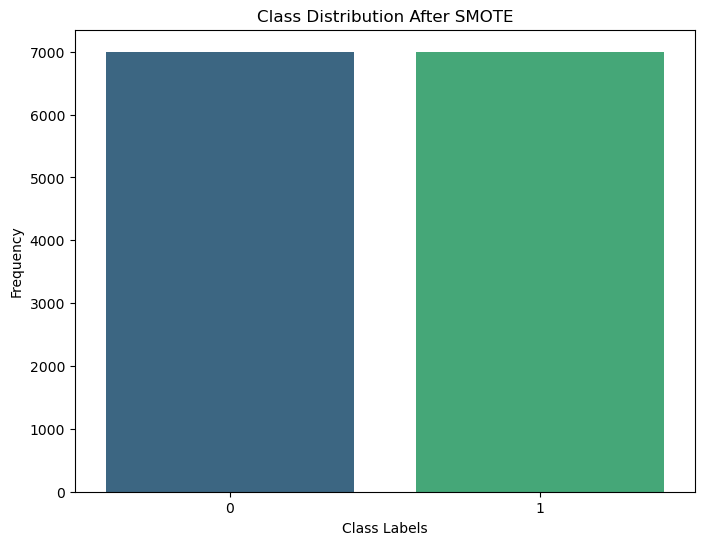

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Count occurrences of each class after SMOTE
unique, counts = np.unique(labels_resampled, return_counts=True)

# Plot the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=unique, y=counts, palette="viridis")
plt.xlabel("Class Labels")
plt.ylabel("Frequency")
plt.title("Class Distribution After SMOTE")
plt.show()


In [25]:
#---------------------- LSTM Model ----------------------
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout=0.5):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        out = self.fc(self.dropout(lstm_out[:, -1, :]))
        return out

# vocab_size: Number of unique words in the vocabulary (30522 for BERT's tokenizer).
# embedding_dim: Size of each word vector (128 in this case).
# hidden_dim: Number of hidden units in the LSTM layer (256).
# output_dim: Number of possible output classes (categories for classification).
# dropout: Reduces overfitting by randomly turning off neurons (set to 0.5).


# Define LSTM model parameters
lstm_model = LSTMClassifier(vocab_size=30522, embedding_dim=128, hidden_dim=256, output_dim=len(set(labels)))
lstm_criterion = nn.CrossEntropyLoss()
lstm_optimizer = optim.Adam(lstm_model.parameters(), lr=1e-3)


# Training loop for LSTM
def train_lstm(model, dataloader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, _, labels in dataloader:
            inputs, labels = inputs.to(torch.long), labels.to(torch.long)  # Ensure proper dtype
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")

train_lstm(lstm_model, train_loader, lstm_criterion, lstm_optimizer)

Epoch 1/5, Loss: 0.5113
Epoch 2/5, Loss: 0.4478
Epoch 3/5, Loss: 0.4435
Epoch 4/5, Loss: 0.4443
Epoch 5/5, Loss: 0.4427


In [26]:
# ---------------------- BERT Model ----------------------
class BERTClassifier(nn.Module):
    def __init__(self, bert_model, output_dim, dropout=0.3):
        super(BERTClassifier, self).__init__()
        self.bert = bert_model
        self.fc = nn.Linear(768, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.fc(self.dropout(outputs.last_hidden_state[:, 0, :]))

# Load BERT model
bert_model = BertModel.from_pretrained("bert-base-uncased")
bert_classifier = BERTClassifier(bert_model, output_dim=len(set(labels)))

# Define loss and optimizer for BERT
bert_criterion = nn.CrossEntropyLoss()
bert_optimizer = optim.Adam(bert_classifier.parameters(), lr=2e-5)

# Training loop for BERT
def train_bert(model, dataloader, criterion, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for input_ids, attention_mask, labels in dataloader:
            input_ids, attention_mask, labels = (
                input_ids.to(torch.long), 
                attention_mask.to(torch.long), 
                labels.to(torch.long)
            )
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(dataloader):.4f}")

train_bert(bert_classifier, train_loader, bert_criterion, bert_optimizer)

Epoch 1/3, Loss: 0.4651
Epoch 2/3, Loss: 0.4474
Epoch 3/3, Loss: 0.4436


In [27]:
# ---------------------- Model Evaluation ----------------------
def evaluate_model(model, dataloader, model_type="LSTM"):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for input_ids, attention_mask, labels in dataloader:
            input_ids, attention_mask, labels = (
                input_ids.to(torch.long), 
                attention_mask.to(torch.long), 
                labels.to(torch.long)
            )

            if model_type == "BERT":
                outputs = model(input_ids, attention_mask)
            else:
                outputs = model(input_ids)

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average="weighted")
    print(f"\n{model_type} Model Performance:\nAccuracy: {acc:.4f}, F1 Score: {f1:.4f}")
    print(classification_report(all_labels, all_preds))


In [28]:
# Evaluate LSTM
evaluate_model(lstm_model, test_loader, model_type="LSTM")


LSTM Model Performance:
Accuracy: 0.7936, F1 Score: 0.7844
              precision    recall  f1-score   support

           0       1.00      0.59      0.74      1400
           1       0.71      1.00      0.83      1400

    accuracy                           0.79      2800
   macro avg       0.85      0.79      0.78      2800
weighted avg       0.85      0.79      0.78      2800



In [29]:
# Evaluate BERT
evaluate_model(bert_classifier, test_loader, model_type="BERT")


BERT Model Performance:
Accuracy: 0.7936, F1 Score: 0.7844
              precision    recall  f1-score   support

           0       1.00      0.59      0.74      1400
           1       0.71      1.00      0.83      1400

    accuracy                           0.79      2800
   macro avg       0.85      0.79      0.78      2800
weighted avg       0.85      0.79      0.78      2800



In [34]:
import torch
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=7)  # Example BERT model
MODEL_SAVE_PATH = "bert_model.pth"

torch.save(model.state_dict(), MODEL_SAVE_PATH)  # Save only model weights
print(f"✅ Model saved at {MODEL_SAVE_PATH}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model saved at bert_model.pth


In [35]:
import torch
from transformers import BertForSequenceClassification

# Define model architecture (must match the saved model)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=7)  # Ensure same num_labels

# Load saved weights
MODEL_SAVE_PATH = "bert_model.pth"
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=torch.device("cpu")))

# Put the model in evaluation mode
model.eval()

print("✅ Model loaded successfully and ready for inference!")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully and ready for inference!


In [39]:
import torch

def predict_accident_details(report, model, tokenizer):
    try:
        # Tokenize input
        inputs = tokenizer(report, return_tensors="pt", truncation=True, padding=True, max_length=512)
        inputs = {key: value.to(model.device) for key, value in inputs.items()}  # Move to model device

        # Ensure model is in evaluation mode
        model.eval()

        # Get predictions without gradient tracking
        with torch.no_grad():
            outputs = model(**inputs)

        # Debugging: Print logits
        print("🔹 Logits:", outputs.logits)

        # Get predicted class
        predicted_class = torch.argmax(outputs.logits, dim=1).item()

        # Define class labels
        primary_causes = ["Rash Driving", "Weather Issues", "Road Conditions", "Helmet Violation", 
                          "Seatbelt Violation", "Signal Violation", "Pedestrian Negligence"]
        secondary_causes = ["DUI-related accident", "Over speeding and reckless maneuvering", "Heavy rain, fog, or slippery roads",
                            "Potholes, construction work, or lack of signs", "Two-wheeler rider not wearing a helmet",
                            "Car passengers not wearing seatbelts", "Jumping red lights or ignoring stop signs",
                            "Jaywalking or crossing in unsafe zones"]

        # Map risk factor (since we only have two categories)
        risk_factors = ["High", "Moderate"]
        risk_mapping = {0: "High", 1: "High", 2: "High", 3: "Moderate", 4: "Moderate", 5: "Moderate", 6: "Moderate"}

        return {
            "Primary Cause": primary_causes[predicted_class] if predicted_class < len(primary_causes) else "Unknown",
            "Secondary Cause": secondary_causes[predicted_class] if predicted_class < len(secondary_causes) else "Unknown",
            "Risk Factor": risk_mapping.get(predicted_class, "Unknown")  # Proper mapping
        }

    except Exception as e:
        print(f"❌ Error: {e}")
        return {"Primary Cause": "Unknown", "Secondary Cause": "Unknown", "Risk Factor": "Unknown"}

# Example Test
sample_report = "On 02 Feb 2024, at 12:16 AM, a truck collided with a two-wheeler at MG Road, Bangalore. Two-wheeler rider not wearing a helmet,Helmet Violation,None,Moderate"

# Ensure model and tokenizer are loaded before calling
predicted_details = predict_accident_details(sample_report, model, tokenizer)

print("\n🔹 Accident Report Analysis 🔹")
for key, value in predicted_details.items():
    print(f"{key}: {value}")


🔹 Logits: tensor([[-0.3200, -0.5335,  0.3298,  0.0367, -0.2124,  0.9106,  0.4587]])

🔹 Accident Report Analysis 🔹
Primary Cause: Signal Violation
Secondary Cause: Car passengers not wearing seatbelts
Risk Factor: Moderate
